In [1]:
import pandas as pd
import numpy as np
import sys
import os
import os.path
import random
from pathlib import Path
from time import time
from itertools import chain
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer,StandardScaler, MinMaxScaler,OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, LSTM, Embedding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow
from kaggle.competitions import twosigmanews
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from keras import regularizers
from keras.constraints import maxnorm
from keras.optimizers import SGD

# Improve printed df readability
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

print(os.listdir("../input"))

Using TensorFlow backend.


['marketdata_sample.csv', 'news_sample.csv']


In [2]:
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
(market, news) = env.get_training_data()

In [4]:
market_idx = market[['time', 'assetCode']]
market_idx = market_idx.sample(3000000)
market_idx = market_idx.sort_values(by=['time'])
market_train_idx, market_test_idx = train_test_split(market_idx,test_size=0.1, shuffle=False, random_state=2018)
market_train_idx, market_val_idx = train_test_split(market_train_idx, test_size=0.1, shuffle=False, random_state=2018)

## Market feature extraction

In [5]:
class MarketPrepro:
    assetcode_encoded = []
    assetcode_train_count = 0
    time_cols=['year', 'week', 'day', 'dayofweek']
    numeric_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
                    'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
                    'returnsOpenPrevMktres10']
    feature_cols = ['assetCode_encoded']  + time_cols + numeric_cols
    label_cols = ['returnsOpenNextMktres10']   
    
    def __init__(self):
        self.cats={}
        
    def fit(self, market_train_df):
        df = market_train_df.copy()
        market_train_df = self.fix_train(market_train_df)
        market_train_df = self.prepare_time_cols(market_train_df)
        self.numeric_scaler = StandardScaler()
        self.numeric_scaler.fit(market_train_df[self.numeric_cols + self.time_cols].astype(float))
        market_train_df = self.encode_asset(market_train_df, True)
        
    def fix_train(self, train_df):
        max_ratio  = 2
        train_df = train_df[(train_df['close'] / train_df['open']).abs() <= max_ratio].loc[:]
        train_df = self.safe_fix(train_df)
        return(train_df)

    def safe_fix(self, df):
        df[self.numeric_cols] = df[ ['assetCode'] + self.numeric_cols].groupby('assetCode').transform(lambda g: g.fillna(method='bfill'))
        df[self.numeric_cols] = df[self.numeric_cols].fillna(0)
        df[self.numeric_cols] = df[self.numeric_cols].clip(df[self.numeric_cols].quantile(0.01), df[self.numeric_cols].quantile(0.99), axis=1)
        return(df)
    
    def get_X(self,df):
        df = df.copy()
        df = self.safe_fix(df)
        df = self.prepare_time_cols(df)
        df = self.encode_asset(df, is_train=False)
        df[self.numeric_cols+self.time_cols] = self.numeric_scaler.transform(df[self.numeric_cols+self.time_cols].astype(float))
        return df[self.feature_cols]
    
    def get_y(self, df):
        y=(df[self.label_cols] >=0).astype(float)
        return y

    def encode_asset(self, df, is_train):
        def encode(assetcode):
            try:
                index_value = self.assetcode_encoded.index(assetcode) +1
            except ValueError:
                self.assetcode_encoded.append(assetcode)
                index_value = len(self.assetcode_encoded)
        if is_train:
            self.assetcode_train_count = len(df['assetCode'].unique())+1
        df['assetCode_encoded'] = df['assetCode'].apply(lambda assetcode: encode(assetcode))
        return(df)
        
    def prepare_time_cols(self, df):
        df = df.copy()
        df['year'] = df['time'].dt.year
        df['day'] = df['time'].dt.day
        df['week'] = df['time'].dt.week
        df['dayofweek'] = df['time'].dt.dayofweek
        return(df)


In [6]:
market_prepro = MarketPrepro()

## News feature extraction

In [7]:
class NewsPrepro:
    news_cols_agg = {
        'urgency': ['min', 'count'],
        'takeSequence': ['max'],
        'bodySize': ['min', 'max', 'mean', 'std'],
        'wordCount': ['min', 'max', 'mean', 'std'],
        'sentenceCount': ['min', 'max', 'mean', 'std'],
        'companyCount': ['min', 'max', 'mean', 'std'],
        'marketCommentary': ['min', 'max', 'mean', 'std'],
        'relevance': ['min', 'max', 'mean', 'std'],
        'sentimentNegative': ['min', 'max', 'mean', 'std'],
        'sentimentNeutral': ['min', 'max', 'mean', 'std'],
        'sentimentPositive': ['min', 'max', 'mean', 'std'],
        'sentimentWordCount': ['min', 'max', 'mean', 'std'],
        'noveltyCount12H': ['min', 'max', 'mean', 'std'],
        'noveltyCount24H': ['min', 'max', 'mean', 'std'],
        'noveltyCount3D': ['min', 'max', 'mean', 'std'],
        'noveltyCount5D': ['min', 'max', 'mean', 'std'],
        'noveltyCount7D': ['min', 'max', 'mean', 'std'],
        'volumeCounts12H': ['min', 'max', 'mean', 'std'],
        'volumeCounts24H': ['min', 'max', 'mean', 'std'],
        'volumeCounts3D': ['min', 'max', 'mean', 'std'],
        'volumeCounts5D': ['min', 'max', 'mean', 'std'],
        'volumeCounts7D': ['min', 'max', 'mean', 'std']
            }
    news_cols_numeric = set(news_cols_agg.keys()) - set(['assetCode', 'time'])
        
    def fit(self, news_train_df):
        news_train_df = news_train_df.copy()
        news_train_df_agg = self.aggregate_news(news_train_df)
        news_train_df_agg.fillna(0, inplace=True)
        self.numeric_scaler = StandardScaler()
        self.numeric_scaler.fit(news_train_df_agg)
        self.feature_cols = list(news_train_df_agg.columns.values)

    def get_X(self, df):
        news_df = df.copy()
        news_df = self.aggregate_news(df)
        news_df.fillna(0, inplace=True)
        if not news_df.empty:
            news_df_numeric = news_df._get_numeric_data().astype(float)
            news_df[news_df_numeric.columns] = self.numeric_scaler.transform(news_df_numeric)
        return(news_df)
        
    def aggregate_news(self, df):
        df['assetCodes'] = df['assetCodes'].str.findall(f"'([\w\./]+)'")    
        if not df.empty: df.time = df.time.astype('datetime64[D, UTC]') 
        assetCodes_expanded = list(chain(*df['assetCodes']))
        
        if(not df.empty): assetCodes_index = df.index.repeat(df['assetCodes'].apply(len)) 
        else: assetCodes_index = df.index
        assert len(assetCodes_index) == len(assetCodes_expanded)
        df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

        news_cols = ['time', 'assetCodes'] + sorted(list(self.news_cols_agg.keys()))
        df_expanded = pd.merge(df_assetCodes, df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))

        df_aggregated = df_expanded.groupby(['time', 'assetCode']).agg(self.news_cols_agg)
        df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]

        return df_aggregated    

In [8]:
news_prepro = NewsPrepro()

**##Merge**

In [9]:
class JoinedPreprocessor:
    def __init__(self, market_prepro, news_prepro):
        self.market_prepro = market_prepro
        self.news_prepro = news_prepro
        
    def fit(self, market_train_idx, market, news):
        market_train_df = market.loc[market_train_idx.index]
        self.market_prepro.fit(market_train_df)
        news_train_df = news.merge(market_train_idx, on=['time'])
        self.news_prepro.fit(news_train_df)
    
    def get_X(self, market_df, news_df):
        market_X = market_prepro.get_X(market_df)
        market_X['time'] = market_df['time']
        market_X['assetCode'] = market_df['assetCode']
        news_X = news_prepro.get_X(news_df)
        X = market_X.merge(news_X, how='left', left_on=['time', 'assetCode'], right_on=['time','assetCode'],  right_index=True)
        X.fillna(0, inplace=True)
        features = X[market_prepro.feature_cols + news_prepro.feature_cols]
        return(features)

    def get_y(self, market_df): 
        return(self.market_prepro.get_y(market_df))
    
    def get_Xy(self, market_df, news_df):
        return(self.get_X(market_df, news_df), self.get_y(market_df))
    
    def fix_train(self, market_df, news_df):
        return(market_prepro.fix_train(market_df), news_df)

In [10]:
prepro = JoinedPreprocessor(market_prepro, news_prepro)
prepro.fit(market.loc[market_train_idx.index], market, news)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int8, int16, float16, float32, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [16]:
class JoinedGenerator:
    def __init__(self, prepro, market, news, index_df):
        self.market = market
        self.prepro = prepro
        self.news = news
        self.index_df = index_df

    def flow_lstm(self, batch_size, is_train, look_back, look_back_step):
        while True:
            batch_index_df = self.get_random_assets_idx(batch_size)
            X, y, = self.get_batch(batch_index_df, is_train)
            index = batch_index_df.index
            X, y,index = self.with_look_back(X,y,index,look_back,look_back_step)
            yield X,y
    
    def get_random_assets_idx(self, batch_size):
        asset_codes = self.index_df['assetCode'].unique().tolist()

        # Insert first asset
        asset = np.random.choice(asset_codes)
        asset_codes.remove(asset)
        batch_index_df = self.index_df[self.index_df.assetCode == asset].tail(batch_size)
        # Repeat until reach batch_size records
        while (batch_index_df.index.size < batch_size) and (len(asset_codes) > 0):
            asset = np.random.choice(asset_codes)
            asset_codes.remove(asset)
            asset_index_df = self.index_df[self.index_df.assetCode == asset].tail(batch_size - batch_index_df.index.size)
            batch_index_df = pd.concat([batch_index_df, asset_index_df])
        
        return batch_index_df.sort_values(by=['assetCode', 'time'])
            
    def get_batch(self, batch_idx, is_train):
        market_df = self.market.loc[batch_idx.index]
        news_df = news.merge(batch_idx, on=['time'])
        if is_train: 
            market_df, news_df = prepro.fix_train(market_df, news_df)
        X = self.prepro.get_X(market_df, news_df)
        y = self.prepro.get_y(market_df)
        return(X, y)
    
    def with_look_back(self, X, y,index,look_back, look_back_step):
        X_processed, y_processed, idx_processed = [], [], []
        if look_back > len(X): 
            look_back = len(X)
            look_back_step = min(look_back_step, look_back)
            
        for i in range(0,len(X)-look_back+1):
            x_window = X.values[i:(i+look_back):look_back_step, :]
            X_processed.append(x_window)
            if y is None: continue
            y_window = y.values[i+look_back-1, :]
            y_processed.append(y_window)
            index_window = index.values[i+look_back-1]
            idx_processed.append(index_window)
        if(y is not None): return np.array(X_processed), np.array(y_processed),idx_processed
        else: return np.array(X_processed)

In [17]:
join_generator = JoinedGenerator(prepro, market, news, market_train_idx)
val_generator = JoinedGenerator(prepro, market, news, market_val_idx)

In [14]:
class lstm_tot:
    look_back=90
    look_back_step=10

    def lstm_128():
        model = Sequential()
        input_size = len(market_prepro.feature_cols) + len(news_prepro.feature_cols)
        model.add(LSTM(units=128, return_sequences=True,input_shape=(None,input_size)))
        model.add(LSTM(units=64, return_sequences=True))
        model.add(LSTM(units=32, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
        model.compile(optimizer= sgd, loss='binary_crossentropy', metrics=['acc'])
        return(model)        

model = lstm_tot.lstm_128()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         116736    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 178,593
Trainable params: 178,593
Non-trainable params: 0
_________________________________________________________________


## Train market and news model

In [18]:
weights_file='best_weights.h5'
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(weights_file
    ,monitor='val_acc'
    ,verbose=1
    ,save_best_only=True
    ,save_weights_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.001)

batch_size=1000
validation_batch_size=1000
steps_per_epoch=20
validation_steps=5
epochs=20

print(f'epochs:{epochs}, steps per epoch: {steps_per_epoch}, validation steps:{validation_steps}')
print(f'Batch_size:{batch_size}, validation batch size:{validation_batch_size}')

training = model.fit_generator(join_generator.flow_lstm(batch_size=batch_size 
            , is_train=True 
            , look_back=lstm_tot.look_back 
            , look_back_step=lstm_tot.look_back_step) 
        , epochs=epochs 
        , validation_data=val_generator.flow_lstm(batch_size=validation_batch_size
            , is_train=False
            , look_back=lstm_tot.look_back
            , look_back_step=lstm_tot.look_back_step) 
        , steps_per_epoch=steps_per_epoch 
        , validation_steps=validation_steps
        , callbacks=[earlystopper, checkpointer, reduce_lr])
model.load_weights(weights_file)

epochs:20, steps per epoch: 20, validation steps:5
Batch_size:1000, validation batch size:1000
Epoch 1/20
20/20 [==============================] - 85s 4s/step - loss: 0.6978 - acc: 0.4918 - val_loss: 0.6936 - val_acc: 0.5067

Epoch 00001: val_acc improved from -inf to 0.50670, saving model to best_weights.h5
Epoch 2/20
20/20 [==============================] - 77s 4s/step - loss: 0.6973 - acc: 0.5109 - val_loss: 0.7092 - val_acc: 0.4720

Epoch 00002: val_acc did not improve from 0.50670
Epoch 3/20
20/20 [==============================] - 76s 4s/step - loss: 0.6938 - acc: 0.5081 - val_loss: 0.6956 - val_acc: 0.5019

Epoch 00003: val_acc did not improve from 0.50670
Epoch 4/20
20/20 [==============================] - 78s 4s/step - loss: 0.6933 - acc: 0.5081 - val_loss: 0.6975 - val_acc: 0.4799

Epoch 00004: val_acc did not improve from 0.50670
Epoch 5/20
20/20 [==============================] - 79s 4s/step - loss: 0.6943 - acc: 0.5038 - val_loss: 0.6964 - val_acc: 0.5071

Epoch 00005: val

In [ ]:
asset_codes = market_test_idx['assetCode'].unique().tolist()
y_pred,idx = [],[]
i = 0
for asset in asset_codes:
    print(i)
    look_back=lstm_tot.look_back
    look_back_step=lstm_tot.look_back_step
    batch_index_df = market_test_idx[market_test_idx.assetCode == asset]
    market_df = market.loc[batch_index_df.index]
    news_df = news.merge(batch_index_df, on=['time'])
    X,y = prepro.get_Xy(market_df, news_df)
    index = batch_index_df.index
    X,y,index = val_generator.with_look_back(X, y,index,look_back=look_back, look_back_step=look_back_step)
    confidence = np.array([model.predict(X)]) * 2 - 1
    y_pred.append(confidence)
    idx.append(index)
    i += 1

In [100]:
num_pred = np.hstack(y_pred).flatten()
num_pred= num_pred.clip(-1,1)
num_index = np.hstack(idx).flatten()
market_df = market.loc[num_index]
time = market_df.time
d_val = time.factorize()[0].tolist()
r_val = market_df.returnsOpenNextMktres10.tolist()
u_val = market_df.universe.tolist()
x_t_i= (num_pred * r_val * u_val).tolist()
df = pd.DataFrame({'day': d_val,'col2': x_t_i,'real':r_val,'pred':num_pred,'universe':u_val}, index=num_index)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score = mean / std
print(score)

0.40154177464945245


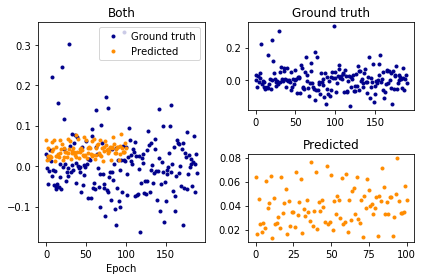

In [71]:
def predict_on_test():
    pred_size=100
    pred_idx = market_test_idx.tail(pred_size + lstm_tot.look_back)
    market_df = market.loc[pred_idx.index]
    news_df = news.merge(pred_idx, on=['time'])
    X_test, y_test = prepro.get_Xy(market_df, news_df)
    index = pred_idx.index
    X_test, y_test,index = join_generator.with_look_back(X_test, y_test, index,look_back = lstm_tot.look_back, look_back_step=lstm_tot.look_back_step)
    y_pred = model.predict(X_test)*2-1

    # Plot
    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
    ax1.plot(market_df['returnsOpenNextMktres10'].values, linestyle='none', marker='.', color='darkblue')
    ax1.plot(y_pred, linestyle='none', marker='.', color='darkorange')
    ax1.legend(["Ground truth","Predicted"])
    ax1.set_title("Both")
    ax1.set_xlabel("Epoch")
    ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1,rowspan=1)
    ax2.plot(market_df['returnsOpenNextMktres10'].values, linestyle='none', marker='.', color='darkblue')
    ax2.set_title("Ground truth")
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1,rowspan=1)
    ax3.plot(y_pred, linestyle='none', marker='.', color='darkorange')
    ax3.set_title("Predicted")
    plt.tight_layout()
    plt.show()

predict_on_test()